### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (2 балл)

4) Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями (1 балл)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [ ]:
len(dataloader)

3750

In [ ]:
for image, cat in dataloader:
    break

In [ ]:
image.size()

torch.Size([16, 1, 28, 28])

In [ ]:
28*28

784

In [ ]:
def clip(m, c):
    if hasattr(m, "weight"):
        m.weight.data.clamp_(-c, c)
    if hasattr(m, "bias") and m.bias is not None:
        m.bias.data.clamp_(-c, c)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [ ]:
D_x = np.zeros(config.num_epochs)
D_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in tqdm(enumerate(dataloader)):
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = -output.mean()
        errD_x.backward()
        D_x[epoch] += output.mean().item() / len(dataloader)

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        output = discriminator(fake.detach())
        errD_z = output.mean()
        errD_z.backward()
        optim_D.step()
        D_z[epoch] += output.mean().item()  / len(dataloader)

        discriminator.apply(lambda m: clip(m, 0.01))

        # generator

        generator.zero_grad()
        output = discriminator(fake)
        errG = -output.mean()
        errG.backward()

        optim_G.step()

    print(f"epoch {epoch+1}:\n D_real = {D_x[epoch]}\n D_fake = {D_z[epoch]}")

3750it [00:24, 156.14it/s]


epoch 1:
 D_real = 0.06283849696465764
 D_fake = 0.00813155859160861


3750it [00:23, 157.90it/s]


epoch 2:
 D_real = 0.035991395790688684
 D_fake = 0.009421629980183184


3750it [00:24, 155.17it/s]


epoch 3:
 D_real = 0.030424511656708435
 D_fake = 0.011168444897762152


3750it [00:23, 156.66it/s]


epoch 4:
 D_real = 0.019615780484195194
 D_fake = 0.010250376733182945


3750it [00:23, 156.48it/s]


epoch 5:
 D_real = 0.016044143077203414
 D_fake = 0.007323551084830756


3750it [00:24, 153.81it/s]


epoch 6:
 D_real = 0.014926703371045506
 D_fake = 0.008739680176763798


3750it [00:24, 152.53it/s]


epoch 7:
 D_real = 0.015981485252874045
 D_fake = 0.012035002279335997


3750it [00:24, 153.61it/s]


epoch 8:
 D_real = 0.009426671813211152
 D_fake = 0.008227350323919138


3750it [00:24, 154.09it/s]


epoch 9:
 D_real = 0.009954596948289977
 D_fake = 0.006914970129914586


3750it [00:24, 151.20it/s]

epoch 10:
 D_real = 0.012867547660646962
 D_fake = 0.011180067409427506


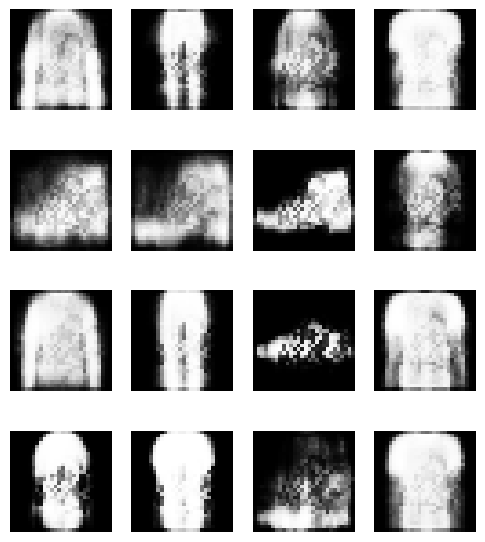

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

В процессе обучения дискриминатор начал деградировать. Простой clipping весов делает модель сильно ограниченной.

## Gradient penalty



In [ ]:
generator = Generator()
discriminator = Discriminator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

In [ ]:
D_x = np.zeros(config.num_epochs)
D_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in tqdm(enumerate(dataloader)):
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = -output.mean()
        errD_x.backward()
        D_x[epoch] += output.mean().item() / len(dataloader)

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        output = discriminator(fake.detach())
        errD_z = output.mean()
        errD_z.backward()
        D_z[epoch] += output.mean().item()  / len(dataloader)

        eps = torch.rand(1).item()
        x_hat = eps * input_data + (1 - eps) * fake.detach()
        x_hat.requires_grad = True
        D_hat = discriminator(x_hat)
        D_hat_grad = torch.autograd.grad(
            outputs=D_hat,
            inputs=x_hat,
            grad_outputs=torch.ones_like(D_hat),
            retain_graph=True,
            create_graph=True
        )[0]
        grad_norm = D_hat_grad.view(images.shape[0], -1).norm(2, dim=1)
        gradient_penalty = 10 * ((grad_norm - 1) ** 2).mean()
        gradient_penalty.backward()
        optim_D.step()

        # generator
        generator.zero_grad()
        output = discriminator(fake)
        errG = -output.mean()
        errG.backward()

        optim_G.step()

    print(f"epoch {epoch+1}:\n D_real = {D_x[epoch]}\n D_fake = {D_z[epoch]}")

3750it [00:29, 126.76it/s]


epoch 1:
 D_real = 3.0317929015666203
 D_fake = 0.536776526952534


3750it [00:30, 124.50it/s]


epoch 2:
 D_real = 1.4239607404385979
 D_fake = -0.21822505575331552


3750it [00:29, 126.15it/s]


epoch 3:
 D_real = 0.9564383071032625
 D_fake = -0.5412286113942663


3750it [00:30, 124.97it/s]


epoch 4:
 D_real = 0.6911358359492084
 D_fake = -0.6444514581978315


3750it [00:29, 127.23it/s]


epoch 5:
 D_real = 0.1543924611272907
 D_fake = -1.0474024025554425


3750it [00:29, 125.23it/s]


epoch 6:
 D_real = -0.12556267743607355
 D_fake = -1.2818856274669372


3750it [00:29, 126.63it/s]


epoch 7:
 D_real = -0.2760726091861722
 D_fake = -1.3908700208127536


3750it [00:29, 125.78it/s]


epoch 8:
 D_real = -0.2602478186195097
 D_fake = -1.2799992911820606


3750it [00:29, 126.11it/s]


epoch 9:
 D_real = -0.13424919734075638
 D_fake = -1.1017409905460973


3750it [00:30, 124.92it/s]

epoch 10:
 D_real = -0.08585658023692697
 D_fake = -0.9945699378396061


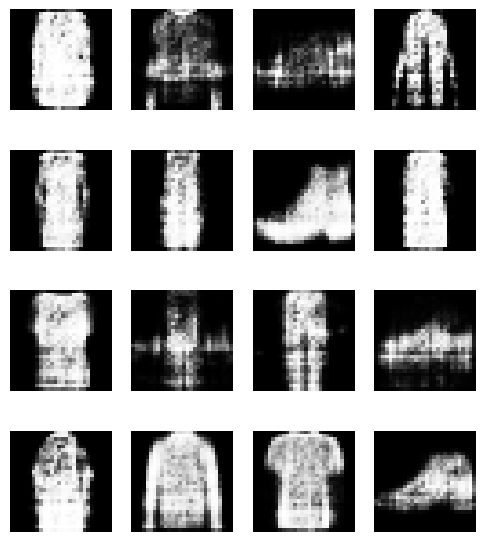

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

C gradient penalty ситуация лучше, картинки лучше начали генерироваться, и по выходу дискриминатора можно сказать что он обучается.

## Условная генерация


Для этой задачи, чтобы модель генерировала по условию, увеличим размерности слоев под one-hot вектор класса, увеличим количество эпох, чтобы модель генерировала почти все картинки требуемого класса.

In [ ]:
num_classes = 10

In [ ]:
class CGenerator(nn.Module):
    def __init__(self):
        super(CGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size + num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class CDiscriminator(nn.Module):
    def __init__(self):
        super(CDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = CGenerator()
discriminator = CDiscriminator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

In [ ]:
generator

CGenerator(
  (model): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
D_x = np.zeros(4 * config.num_epochs)
D_z = np.zeros(4 * config.num_epochs)
ERRG = np.zeros(4 * config.num_epochs)
N = len(dataloader)

for epoch in range(4 * config.num_epochs):
    for iteration, (images, cat) in tqdm(enumerate(dataloader)):
        discriminator.zero_grad()

        condition = F.one_hot(torch.tensor(cat), num_classes)
        # real

        input_data = torch.cat([images.view(images.shape[0], -1), condition], dim=1)
        output = discriminator(input_data)
        errD_x = -output.mean()
        errD_x.backward()
        D_x[epoch] += output.mean().item() / len(dataloader)

        # fake
        noise.data.normal_(0, 1)
        noise_condition = torch.cat([noise, condition], dim=1)
        fake = torch.cat([generator(noise_condition), condition], dim=1)
        output = discriminator(fake.detach())
        errD_z = output.mean()
        errD_z.backward()
        D_z[epoch] += output.mean().item()  / len(dataloader)

        eps = torch.rand(1).item()
        x_hat = eps * input_data + (1 - eps) * fake.detach()
        x_hat.requires_grad = True

        D_hat = discriminator(x_hat)
        D_hat_grad = torch.autograd.grad(
            outputs=D_hat,
            inputs=x_hat,
            grad_outputs=torch.ones_like(D_hat),
            retain_graph=True,
            create_graph=True
        )[0]
        grad_norm = D_hat_grad.view(images.shape[0], -1).norm(2, dim=1)
        gradient_penalty = 10 * ((grad_norm - 1) ** 2).mean()
        gradient_penalty.backward()
        optim_D.step()

        # generator
        generator.zero_grad()
        output = discriminator(fake)
        errG = -output.mean()
        errG.backward()

        optim_G.step()

    print(f"epoch {epoch+1}:\n D_real = {D_x[epoch]}\n D_fake = {D_z[epoch]}")

0it [00:00, ?it/s]/tmp/ipython-input-802924120.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  condition = F.one_hot(torch.tensor(cat), num_classes)
3750it [00:30, 121.09it/s]


epoch 1:
 D_real = 2.941113222407803
 D_fake = 0.5132749611216281


3750it [00:30, 122.32it/s]


epoch 2:
 D_real = 1.4484084852638353
 D_fake = -0.4435529082144299


3750it [00:30, 122.04it/s]


epoch 3:
 D_real = 1.5271354256818737
 D_fake = -0.28822724879533296


3750it [00:30, 122.74it/s]


epoch 4:
 D_real = 1.8788904770761774
 D_fake = 0.2595285586141059


3750it [00:30, 123.73it/s]


epoch 5:
 D_real = 1.8298036262422763
 D_fake = 0.34079422371052304


3750it [00:30, 124.63it/s]


epoch 6:
 D_real = 1.750398382893201
 D_fake = 0.34141696278949635


3750it [00:30, 123.52it/s]


epoch 7:
 D_real = 1.6820161323269238
 D_fake = 0.3252721807117266


3750it [00:30, 124.78it/s]


epoch 8:
 D_real = 1.6391344438813646
 D_fake = 0.3258200186102343


3750it [00:30, 123.58it/s]


epoch 9:
 D_real = 1.5819304471492772
 D_fake = 0.31510469385993883


3750it [00:30, 123.87it/s]


epoch 10:
 D_real = 1.536240776683644
 D_fake = 0.32768149330504204


3750it [00:30, 123.34it/s]


epoch 11:
 D_real = 1.4254399397686153
 D_fake = 0.2475233137747896


3750it [00:30, 124.07it/s]


epoch 12:
 D_real = 1.2428501838284254
 D_fake = 0.10864868050590146


3750it [00:30, 121.46it/s]


epoch 13:
 D_real = 1.1547160486196442
 D_fake = 0.04332893878594057


3750it [00:30, 123.98it/s]


epoch 14:
 D_real = 1.0259436181751413
 D_fake = -0.05961712586432704


3750it [00:30, 123.93it/s]


epoch 15:
 D_real = 1.0431368674544004
 D_fake = -0.008859619866311558


3750it [00:30, 124.25it/s]


epoch 16:
 D_real = 0.9240286584558569
 D_fake = -0.07760339076419664


3750it [00:30, 123.53it/s]


epoch 17:
 D_real = 0.8918630510109146
 D_fake = -0.07930785687416804


3750it [00:30, 124.08it/s]


epoch 18:
 D_real = 0.8394267772482085
 D_fake = -0.10663187364637848


3750it [00:30, 123.42it/s]


epoch 19:
 D_real = 0.8295372044406848
 D_fake = -0.07019203875946511


3750it [00:30, 122.30it/s]


epoch 20:
 D_real = 0.8165617080330843
 D_fake = -0.043567434515059004


3750it [00:30, 123.01it/s]


epoch 21:
 D_real = 0.7748983134514315
 D_fake = -0.05153100527599445


3750it [00:30, 122.69it/s]


epoch 22:
 D_real = 0.7381065963541459
 D_fake = -0.055357618088026896


3750it [00:30, 123.54it/s]


epoch 23:
 D_real = 0.6668429197221979
 D_fake = -0.0945819062968098


3750it [00:30, 124.01it/s]


epoch 24:
 D_real = 0.6258552806925026
 D_fake = -0.11537025367338227


3750it [00:30, 122.37it/s]


epoch 25:
 D_real = 0.6037767437475432
 D_fake = -0.10474205449260775


3750it [00:30, 123.41it/s]


epoch 26:
 D_real = 0.5856112203060329
 D_fake = -0.0942243168228618


3750it [00:30, 123.17it/s]


epoch 27:
 D_real = 0.598133191562816
 D_fake = -0.06098036028581353


3750it [00:30, 123.18it/s]


epoch 28:
 D_real = 0.5684022746841103
 D_fake = -0.07273891229890263


3750it [00:30, 122.07it/s]


epoch 29:
 D_real = 0.5786420105285955
 D_fake = -0.04116478859186184


3750it [00:30, 122.30it/s]


epoch 30:
 D_real = 0.5695876584174734
 D_fake = -0.026458191397289336


3750it [00:30, 121.78it/s]


epoch 31:
 D_real = 0.6322362178603813
 D_fake = 0.060734155056253035


3750it [00:30, 123.03it/s]


epoch 32:
 D_real = 0.6200289020766822
 D_fake = 0.06969955649847784


3750it [00:30, 123.06it/s]


epoch 33:
 D_real = 0.6367156328788637
 D_fake = 0.10706357431883619


3750it [00:30, 123.20it/s]


epoch 34:
 D_real = 0.6161103761921342
 D_fake = 0.12148283519583454


3750it [00:30, 123.02it/s]


epoch 35:
 D_real = 0.5916752341037002
 D_fake = 0.1268720009011528


3750it [00:30, 121.59it/s]


epoch 36:
 D_real = 0.5496098131907478
 D_fake = 0.09801681860337641


3750it [00:30, 122.97it/s]


epoch 37:
 D_real = 0.5717105531973142
 D_fake = 0.13291275264626998


3750it [00:30, 122.34it/s]


epoch 38:
 D_real = 0.5484335945496948
 D_fake = 0.1231369188236695


3750it [00:30, 122.16it/s]


epoch 39:
 D_real = 0.5414413234959043
 D_fake = 0.12789952170569438


3750it [00:30, 123.29it/s]

epoch 40:
 D_real = 0.5981745656268055
 D_fake = 0.18748414340031597


In [ ]:
classes = {
    "t-shirt": 0,
    "dress": 3,
    "sneaker": 7,
    "bag": 8,
    "ankle_boot": 9
}

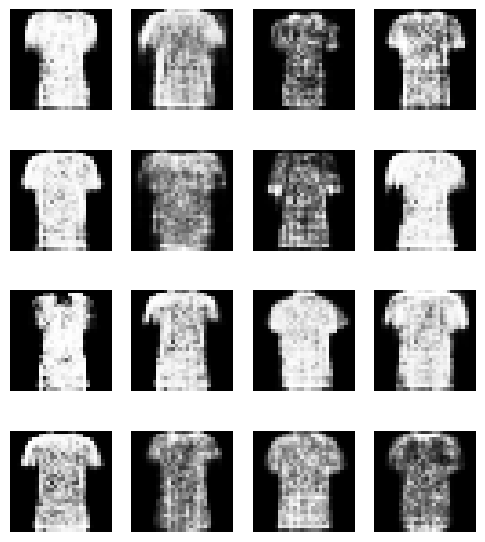

In [ ]:
batch_size = 16
labels = torch.full((batch_size,), classes["t-shirt"], dtype=torch.long)
condition = F.one_hot(labels, num_classes=num_classes)

input = torch.cat([noise.data.normal_(0, 1), condition], dim=1)
fake = generator(input)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')


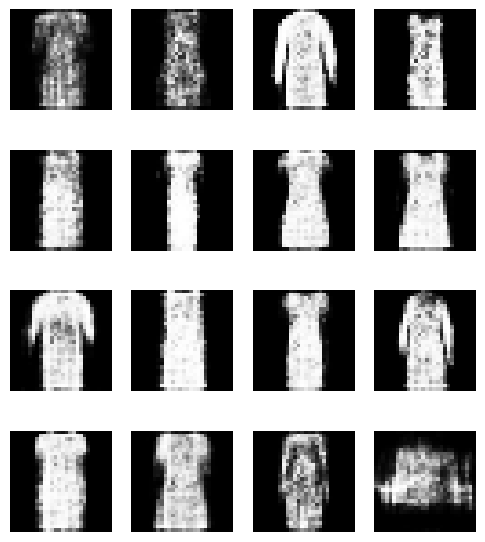

In [ ]:
batch_size = 16
labels = torch.full((batch_size,), classes["dress"], dtype=torch.long)
condition = F.one_hot(labels, num_classes=num_classes)

input = torch.cat([noise.data.normal_(0, 1), condition], dim=1)
fake = generator(input)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')


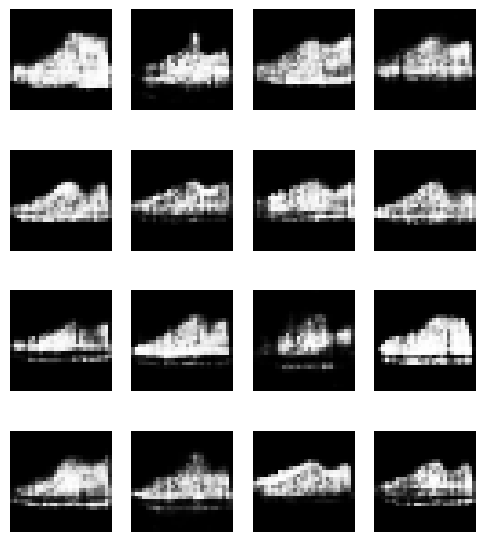

In [ ]:
batch_size = 16
labels = torch.full((batch_size,), classes["sneaker"], dtype=torch.long)
condition = F.one_hot(labels, num_classes=num_classes)

input = torch.cat([noise.data.normal_(0, 1), condition], dim=1)
fake = generator(input)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')


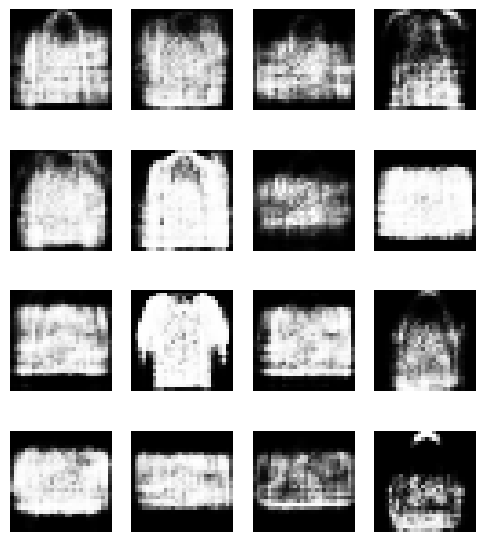

In [ ]:
batch_size = 16
labels = torch.full((batch_size,), classes["bag"], dtype=torch.long)
condition = F.one_hot(labels, num_classes=num_classes)

input = torch.cat([noise.data.normal_(0, 1), condition], dim=1)
fake = generator(input)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')


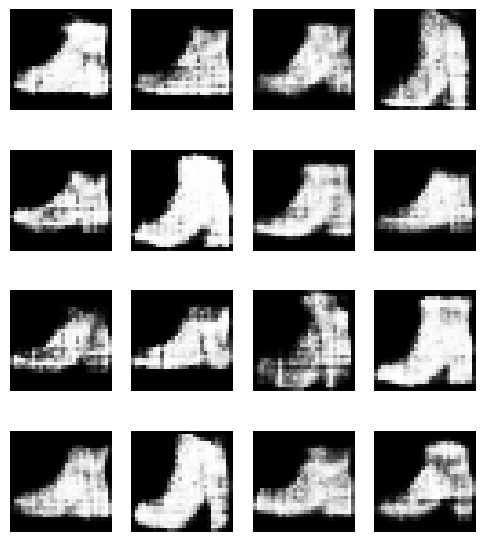

In [ ]:
batch_size = 16
labels = torch.full((batch_size,), classes["ankle_boot"], dtype=torch.long)
condition = F.one_hot(labels, num_classes=num_classes)

input = torch.cat([noise.data.normal_(0, 1), condition], dim=1)
fake = generator(input)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
